# Base Model

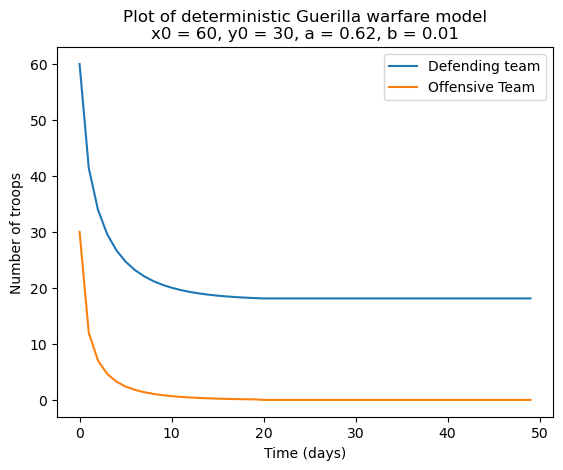

In [27]:
import numpy as np
import matplotlib.pyplot as plt

#Discrete Guerilla Warfare Equations
x_i1 = lambda a, x_i, y_i: x_i - a*y_i
y_i1 = lambda b, x_i, y_i: y_i - b*x_i*y_i

def gw_discrete_time(IC, params, n = 50):
    x, y = np.zeros(n), np.zeros(n)
    a, b = params[0], params[1]
    x[0], y[0] = IC[0], IC[1]
    t = np.zeros(n)

    for i in range(1,n):
        t[i] = i
        x[i] = x_i1(a, x[i-1], y[i-1])
        if x[i] < 0.1: #Set to 0 if value drops below 0.1, conflict effectively over
            x[i] = 0
        y[i] = y_i1(b, x[i-1], y[i-1])
        if y[i] < 0.1: 
            y[i] = 0
    
    return t, x, y

IC = (60, 30)
params = (0.62, 0.01)

t_d, x_d, y_d = gw_discrete_time(IC, params)

plt.plot(t_d, x_d, label = "Defending team")
plt.plot(t_d, y_d, label = "Offensive Team")
plt.xlabel("Time (days)")
plt.ylabel("Number of troops")
plt.title(f"Plot of deterministic Guerilla warfare model\nx0 = {IC[0]}, y0 = {IC[1]}, a = {params[0]}, b = {params[1]}")
plt.legend()
plt.show()

# Markov Chain Representation

In [28]:
def markov_generator(IC, params):
    x0, y0 = IC[0], IC[1]
    length = (x0 + 1)*(y0 + 1)
    a, b = params[0], params[1]
    M = np.zeros((length, length)) #Technically (0,0) is a state in this matrix, but it will never be reached (kept in to simplify construction)
    for i in range(length):
        #Determining x and y values for each row of the matrix
        x = i//(y0 + 1)
        y = i%(y0 + 1)
        if x > 0 and y > 0: #If there are troops from both sides remaining
            x_prob = a*y
            y_prob = b*x*y
            total_prob = x_prob + y_prob
            M[i][i - y0 - 1] = x_prob/total_prob
            M[i][i - 1] = y_prob/total_prob
        else: #If the state is absorbing, always stay at that state
            M[i][i] = 1
    return M

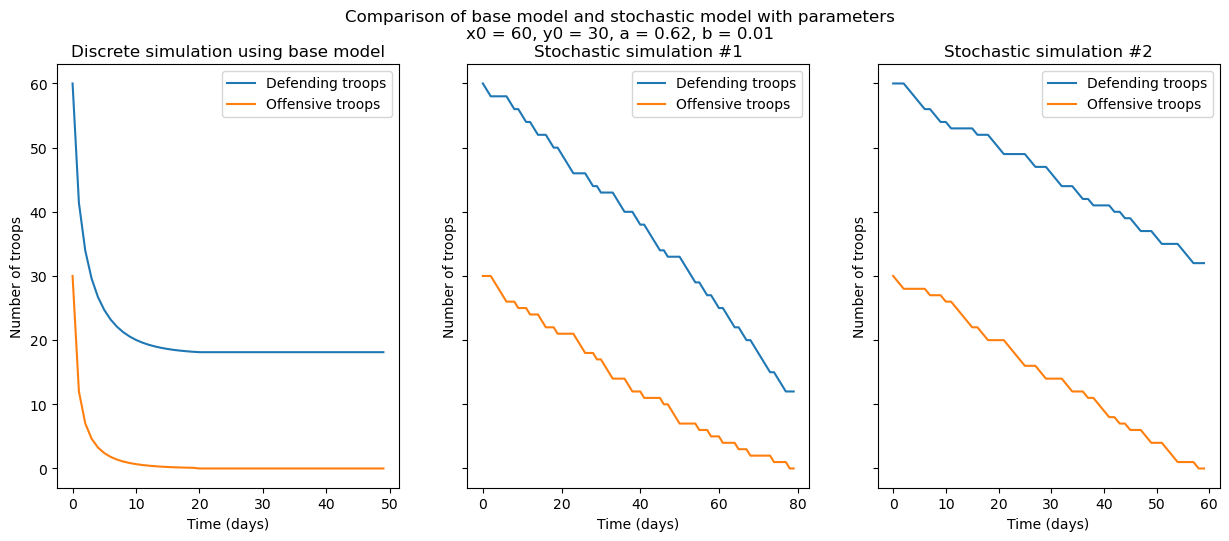

In [29]:
def simulate_conflict(M, IC, max_iter = 100):
    x0, y0 = IC[0], IC[1]
    pos = [len(M) - 1]
    x, y, t = [x0], [y0], [0]
    for i in range(max_iter): 
        pos_next = np.random.choice(len(M), p = M[pos[-1]]) #Chooses state to move to depending on probabilites defind in construction
        x.append(pos_next//(y0 +1)) #Retreiving x value from state index
        y.append(pos_next%(y0+1)) #Retreiving y value from state index
        t.append(i + 1)
        if pos_next == pos[-1]: #If at an absorbing state, end simulation
            return pos + [pos_next], t, x, y
        else:
            pos += [pos_next]
    return -1

IC = (60, 30)
params = (0.62, 0.01)
M = markov_generator(IC, params)
fig, axs = plt.subplots(1, 3, figsize = (15, 5.5), sharey = True)
fig.suptitle(f"Comparison of base model and stochastic model with parameters\nx0 = {IC[0]}, y0 = {IC[1]}, a = {params[0]}, b = {params[1]}")
axs[0].plot(t_d, x_d, label = "Defending troops")
axs[0].plot(t_d, y_d, label = "Offensive troops")
axs[0].set(xlabel = "Time (days)", ylabel = "Number of troops", title = "Discrete simulation using base model")
axs[0].legend()
for i in range(1, 3): #Plotting two simulations of stochastic Guerilla Warfare
    sol, t, x, y = simulate_conflict(M, IC)
    axs[i].plot(t, x, label = "Defending troops")
    axs[i].plot(t, y, label = "Offensive troops")
    axs[i].set(xlabel = "Time (days)", ylabel = "Number of troops", title = f"Stochastic simulation #{i}")
    axs[i].legend()
plt.show()

# Monte Carlo Simulation

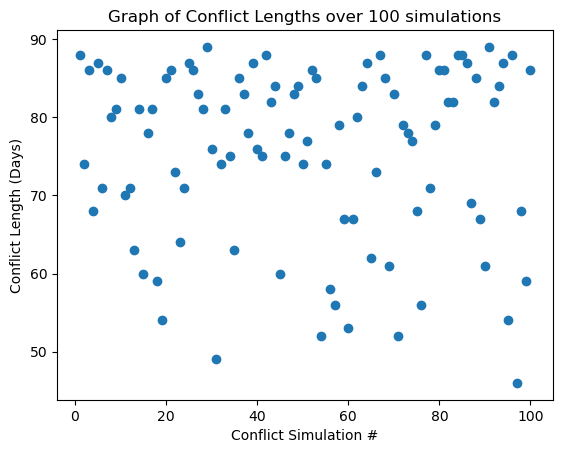

Average conflict length = 75.8002 days
Average conflict length for defending wins = 66.54324097397145
Average conflict length for offensive wins = 84.22268907563026
Average number of defending soldiers remaining in wins = 23.456759026028546
Average number of offensive soldiers remaining in wins = 5.777310924369748
Defending team wins: 2618
Offensive team wins: 2618
Offensive team wins 52.36% of battles


In [30]:
def monte_carlo(M, IC, max_iter = 100, n = 5000):
    x_winners, y_winners = [], []
    n_track = []
    x_wins, y_wins = 0, 0
    conflict_lengths = []
    x_lengths, y_lengths = [], []
    for i in range(n):
        sol, _, x, y = simulate_conflict(M, IC, max_iter = max_iter)
        con_len = len(sol) - 2
        conflict_lengths.append(con_len)
        n_track.append(i + 1)
        if x[-1] == 0:
            y_winners.append(y[-1])
            y_lengths.append(con_len)
            y_wins += 1
        else:
            x_winners.append(x[-1])
            x_lengths.append(con_len)
            x_wins += 1
    plt.scatter(n_track[:100], conflict_lengths[:100]) #Plotting length of first 100 conflicts (for clarity)
    plt.xlabel("Conflict Simulation #")
    plt.ylabel("Conflict Length (Days)")
    plt.title("Graph of Conflict Lengths over 100 simulations")
    plt.show()
    print(f"Average conflict length = {sum(conflict_lengths)/n} days")
    print(f"Average conflict length for defending wins = {sum(x_lengths)/x_wins}")
    print(f"Average conflict length for offensive wins = {sum(y_lengths)/y_wins}")
    print(f"Average number of defending soldiers remaining in wins = {sum(x_winners)/x_wins}")
    print(f"Average number of offensive soldiers remaining in wins = {sum(y_winners)/y_wins}")
    return x_wins, y_wins
mc_simulation = monte_carlo(M, IC)
print(f"Defending team wins: {mc_simulation[1]}\nOffensive team wins: {mc_simulation[1]}")
y_percentage = mc_simulation[1]/50
print(f"Offensive team wins {y_percentage}% of battles")

# Testing Different Strategies

### Strategy 1: Defending team backloads, offensive team evenly loads

In [31]:
x_wars = 0
n = 100          #Expanded to 1000 for the purposes of the report, greatly extends processing time
for _ in range(n):
    x_tot = 2400
    y_tot = 1200
    x_wins = 0
    y_wins = 0
    for i in range(40):
        if i < 1:
            IC = [1, int(y_tot/(40 - i))]
            x_tot -= 1 #Defending team only send 1 troop to the first battle
            y_tot -= int(y_tot/(40 - i))
        else:
            IC = [int(x_tot/(40 - i)), int(y_tot/(40 - i))]
            x_tot -= int(x_tot/(40 - i))
            y_tot -= int(y_tot/(40 - i))
        M = markov_generator(IC, params)
        sol, _, x, y = simulate_conflict(M, IC, max_iter = 100)
        if x[-1] == 0:
            y_wins += 1
        else:
            x_wins += 1
    if x_wins > y_wins: #A war is won if the team wins a majority of battles
        x_wars += 1
x_percentage = x_wars*100/n
print(f"Winning percentage of defending team over 100 wars = {x_percentage}")
print(f"Winning percentage of offensive team over 100 wars = {100 - x_percentage}")

Winning percentage of defending team over 100 wars = 75.0
Winning percentage of offensive team over 100 wars = 25.0


### Strategy 2: Both teams backload

In [32]:
x_wars = 0
for _ in range(n): 
    x_tot = 2400
    y_tot = 1200
    x_wins = 0
    y_wins = 0
    for i in range(40):
        if i < 1:
            IC = [1, 1]
            x_tot -= 1
            y_tot -= 1
        else:
            IC = [int(x_tot/(40 - i)), int(y_tot/(40 - i))]
            x_tot -= int(x_tot/(40 - i))
            y_tot -= int(y_tot/(40 - i))
        M = markov_generator(IC, params)
        sol, _, x, y = simulate_conflict(M, IC, max_iter = 100)
        if x[-1] == 0:
            y_wins += 1
        else:
            x_wins += 1
    if x_wins > y_wins:
        x_wars += 1
x_percentage = x_wars*100/n
print(f"Winning percentage of defending team over 100 wars = {x_percentage}")
print(f"Winning percentage of offensive team over 100 wars = {100 - x_percentage}")

Winning percentage of defending team over 100 wars = 42.0
Winning percentage of offensive team over 100 wars = 58.0


### Strategy 3: Defending team evenly loads, offensive team backloads

In [33]:
x_wars = 0
for _ in range(n):
    x_tot = 2400
    y_tot = 1200
    x_wins = 0
    y_wins = 0
    for i in range(40):
        if i < 1:
            IC = [int(y_tot/(40 - i)), 1]
            x_tot -= int(x_tot/(40 - i))
            y_tot -= 1
        else:
            IC = [int(x_tot/(40 - i)), int(y_tot/(40 - i))]
            x_tot -= int(x_tot/(40 - i))
            y_tot -= int(y_tot/(40 - i))
        M = markov_generator(IC, params)
        sol, _, x, y = simulate_conflict(M, IC, max_iter = 100)
        if x[-1] == 0:
            y_wins += 1
        else:
            x_wins += 1
    if x_wins > y_wins:
        x_wars += 1
x_percentage = x_wars*100/n
print(f"Winning percentage of defending team over 100 wars = {x_percentage}")
print(f"Winning percentage of offensive team over 100 wars = {100 - x_percentage}")

Winning percentage of defending team over 100 wars = 20.0
Winning percentage of offensive team over 100 wars = 80.0


### Strategy 4: Both teams evenly load

In [34]:
x_wars = 0
for _ in range(n):
    x_tot = 2400
    y_tot = 1200
    x_wins = 0
    y_wins = 0
    for i in range(40):
        IC = [int(x_tot/(40 - i)), int(y_tot/(40 - i))]
        x_tot -= int(x_tot/(40 - i))
        y_tot -= int(y_tot/(40 - i))
        M = markov_generator(IC, params)
        sol, _, x, y = simulate_conflict(M, IC, max_iter = 100)
        if x[-1] == 0:
            y_wins += 1
        else:
            x_wins += 1
    if x_wins > y_wins:
        x_wars += 1
x_percentage = x_wars*100/n
print(f"Winning percentage of defending team over 100 wars = {x_percentage}")
print(f"Winning percentage of offensive team over 100 wars = {100 - x_percentage}")

Winning percentage of defending team over 100 wars = 42.0
Winning percentage of offensive team over 100 wars = 58.0


### Graphing Remaining Soldiers After 2 Wars (Both Backloading)

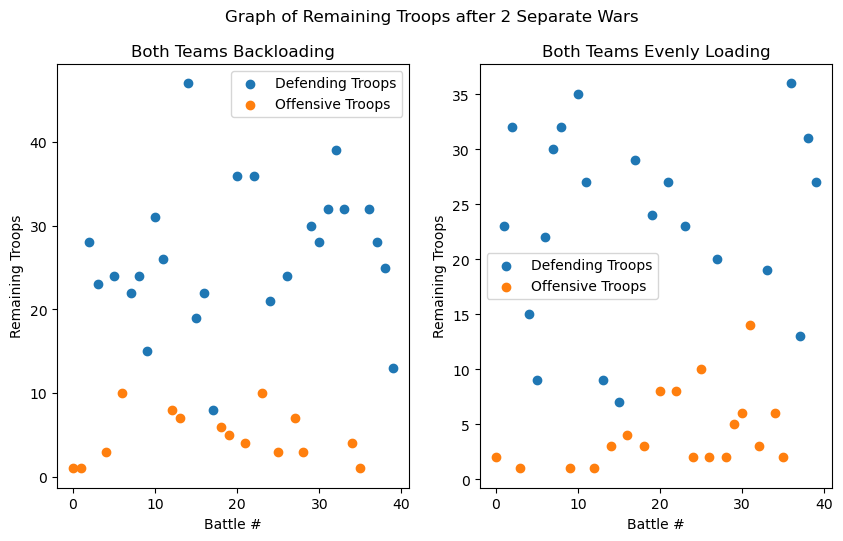

In [35]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5.5))
for w in range(2): 
    x_tot = 2400
    y_tot = 1200
    x_rem = np.empty(40, dtype = np.double)
    y_rem = np.empty(40, dtype = np.double)
    for i in range(40):
        if w == 0 and i < 1: #Both teams backloading
            IC = [1, 1]
            x_tot -= 1
            y_tot -= 1
        else: #Both teams evenly loading
            IC = [int(x_tot/(40 - i)), int(y_tot/(40 - i))]
            x_tot -= int(x_tot/(40 - i))
            y_tot -= int(y_tot/(40 - i))
        M = markov_generator(IC, params)
        sol, _, x, y = simulate_conflict(M, IC, max_iter = 100)
        if x[-1] == 0:
            y_rem[i] = y[-1]
        else:
            x_rem[i] = x[-1]  
        x_rem[i] = x[-1] 
        y_rem[i] = y[-1] 
    x_rem[ x_rem == 0 ] = np.nan #Do not plot if team lost battle
    y_rem[ y_rem == 0 ] = np.nan
    axs[w].scatter(range(40), x_rem, label = "Defending Troops")
    axs[w].scatter(range(40), y_rem, label = "Offensive Troops")
    axs[w].set(xlabel = "Battle #", ylabel = "Remaining Troops")
    axs[w].legend()
axs[0].set(title = "Both Teams Backloading")
axs[1].set(title = "Both Teams Evenly Loading")
plt.suptitle("Graph of Remaining Troops after 2 Separate Wars")
plt.show()

### Game Theory Analysis/Nash Equilibrium

In [36]:
import nashpy as nash

#Values in these payout tables based on 1000 wars simulated for each combination of strategies
D = np.array([
    [32.6, 21.1],
    [65.7, 49.8]
])

O = np.array([
    [67.4, 78.9],
    [34.3, 50.2]
])

gw = nash.Game(D, O) #Creates normal form game using payouts defined in 'D' and 'O'
equilibria = gw.support_enumeration() #Solves nash equilibria (single in this case) using support enumeration
for eq in equilibria:
    print(eq)
print("Therefore, the nash equilibria is when both sides decide to 'backload' their troops")

(array([0., 1.]), array([0., 1.]))
Therefore, the nash equilibria is when both sides decide to 'backload' their troops
